analyze

In [1]:
import os
from collections import defaultdict

# Path to the dataset
DATASET_PATH = "Dataset_2025/Train"

# Dictionary to hold counts for each group like '1f', '2m', etc.
group_counts = defaultdict(int)

# Total file count
total_files = 0

# Loop through all files in the folder
for filename in os.listdir(DATASET_PATH):
    if filename.endswith(".wav"):
        total_files += 1
        # Extract group code from the filename, e.g., "1f" from "1f_1018.wav"
        group_code = filename.split("_")[0]
        group_counts[group_code] += 1

# Print results
print(f"🔢 Total .wav files: {total_files}")
print("📊 File counts per group (accent + gender):")
for group_code in sorted(group_counts.keys()):
    print(f"  {group_code}: {group_counts[group_code]} files")


🔢 Total .wav files: 3166
📊 File counts per group (accent + gender):
  1f: 520 files
  1m: 220 files
  2f: 287 files
  2m: 339 files
  3f: 242 files
  3m: 322 files
  4f: 357 files
  4m: 397 files
  5f: 233 files
  5m: 249 files


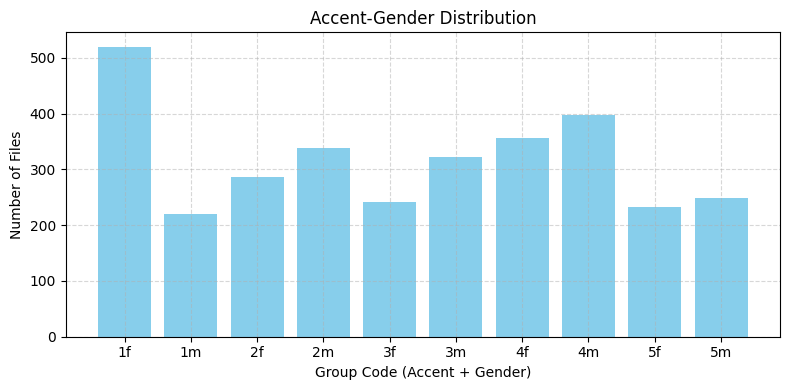

In [2]:
import matplotlib.pyplot as plt

groups = list(group_counts.keys())
counts = [group_counts[k] for k in groups]

plt.figure(figsize=(8, 4))
plt.bar(groups, counts, color='skyblue')
plt.title("Accent-Gender Distribution")
plt.xlabel("Group Code (Accent + Gender)")
plt.ylabel("Number of Files")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [3]:
# Example: Compute class weights
import torch

group_to_accent = {k: int(k[0]) for k in group_counts}
accent_counts = {}
for k, v in group_counts.items():
    a = group_to_accent[k]
    accent_counts[a] = accent_counts.get(a, 0) + v

# Inverse frequency for weighting
total = sum(accent_counts.values())
class_weights = [total / accent_counts[i] for i in sorted(accent_counts)]

print("Class weights (Accent 1 to 5):", class_weights)
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights))


Class weights (Accent 1 to 5): [4.278378378378378, 5.057507987220447, 5.613475177304965, 4.19893899204244, 6.568464730290456]


🎧 Number of files: 3166
⏱️ Min duration: 1.67 s
⏱️ Max duration: 12.97 s
⏱️ Avg duration: 5.26 s


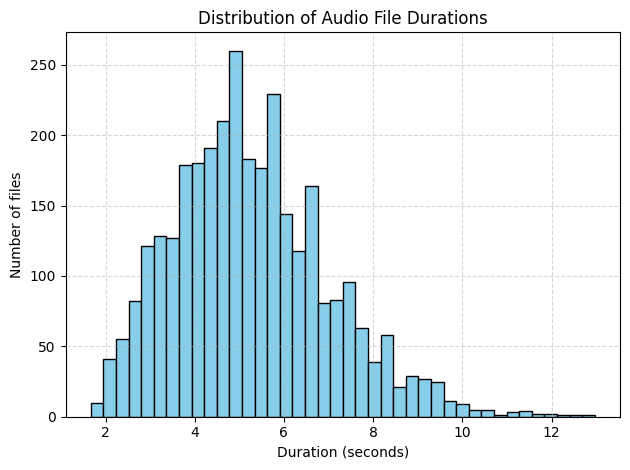

In [5]:
import os
import torchaudio
import matplotlib.pyplot as plt

dataset_path = "Dataset_2025/Train"
durations = []

for fname in os.listdir(dataset_path):
    if fname.endswith(".wav"):
        waveform, sr = torchaudio.load(os.path.join(dataset_path, fname))
        durations.append(waveform.shape[1] / sr)  # duration in seconds

# Stats
print(f"🎧 Number of files: {len(durations)}")
print(f"⏱️ Min duration: {min(durations):.2f} s")
print(f"⏱️ Max duration: {max(durations):.2f} s")
print(f"⏱️ Avg duration: {sum(durations)/len(durations):.2f} s")

# Histogram
plt.hist(durations, bins=40, color='skyblue', edgecolor='black')
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of files")
plt.title("Distribution of Audio File Durations")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


Apply and Save Augmented Files

In [15]:
import os
import torchaudio
import torch
from torchaudio import transforms
import random
import torchaudio.functional as F

# Paths
INPUT_DIR = "Dataset_2025/Train"
OUTPUT_DIR = "Dataset_2025_augmented/Train"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def time_shift(waveform, max_shift_pct=0.1):
    shift_amt = int(waveform.size(1) * random.uniform(-max_shift_pct, max_shift_pct))
    return torch.roll(waveform, shifts=shift_amt)

def volume_change(waveform, gain_db=3.0):
    gain = random.uniform(-gain_db, gain_db)
    return waveform * (10 ** (gain / 20))

def speed_change(waveform, sample_rate, min_rate=0.9, max_rate=1.1):
    speed_factor = random.uniform(min_rate, max_rate)
    new_sample_rate = int(sample_rate * speed_factor)
    waveform = F.resample(waveform, orig_freq=sample_rate, new_freq=new_sample_rate)
    return F.resample(waveform, orig_freq=new_sample_rate, new_freq=sample_rate)

# Process all wav files
i = 0
for filename in os.listdir(INPUT_DIR):
    if not filename.endswith(".wav"):
        continue

    i += 1
    base_name = filename[:-4]
    speed_out = os.path.join(OUTPUT_DIR, f"{base_name}_speed.wav")
    shift_out = os.path.join(OUTPUT_DIR, f"{base_name}_shift.wav")
    volume_out = os.path.join(OUTPUT_DIR, f"{base_name}_volume.wav")

    # Skip if all augmented files exist
    if os.path.exists(speed_out) and os.path.exists(shift_out) and os.path.exists(volume_out):
        print(f"{i}: ⏭️ Skipping {filename} (already augmented)")
        continue

    print(f"{i}: 🔄 Processing {filename}")
    in_path = os.path.join(INPUT_DIR, filename)
    waveform, sr = torchaudio.load(in_path)

    # Augment 1: Speed
    aug_speed = speed_change(waveform, sr)
    torchaudio.save(speed_out, aug_speed, sr)

    # Augment 2: Time Shift
    aug_shift = time_shift(waveform)
    torchaudio.save(shift_out, aug_shift, sr)

    # Augment 3: Volume
    aug_volume = volume_change(waveform)
    torchaudio.save(volume_out, aug_volume, sr)

print("✅ All augmentation completed.")


1: ⏭️ Skipping 1f_1018.wav (already augmented)
2: ⏭️ Skipping 1f_1026.wav (already augmented)
3: ⏭️ Skipping 1f_1031.wav (already augmented)
4: ⏭️ Skipping 1f_1070.wav (already augmented)
5: ⏭️ Skipping 1f_1075.wav (already augmented)
6: ⏭️ Skipping 1f_1079.wav (already augmented)
7: ⏭️ Skipping 1f_1082.wav (already augmented)
8: ⏭️ Skipping 1f_1087.wav (already augmented)
9: ⏭️ Skipping 1f_1129.wav (already augmented)
10: ⏭️ Skipping 1f_1137.wav (already augmented)
11: ⏭️ Skipping 1f_1155.wav (already augmented)
12: ⏭️ Skipping 1f_1161.wav (already augmented)
13: ⏭️ Skipping 1f_1165.wav (already augmented)
14: ⏭️ Skipping 1f_1201.wav (already augmented)
15: ⏭️ Skipping 1f_1206.wav (already augmented)
16: ⏭️ Skipping 1f_1207.wav (already augmented)
17: ⏭️ Skipping 1f_1255.wav (already augmented)
18: ⏭️ Skipping 1f_1279.wav (already augmented)
19: ⏭️ Skipping 1f_1327.wav (already augmented)
20: ⏭️ Skipping 1f_1341.wav (already augmented)
21: ⏭️ Skipping 1f_1354.wav (already augmented)
2

trim to 7 seconds and extract labels

In [16]:
class AccentDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, fixed_len_samples=112000, transform=None):
        self.file_paths = file_list
        self.fixed_len = fixed_len_samples
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        filename = os.path.basename(file_path)
        label = int(filename[0]) - 1  # convert '1f_123.wav' → 0-based class

        waveform, sr = torchaudio.load(file_path)
        waveform = self.pad_or_trim(waveform, self.fixed_len)

        if self.transform:
            waveform = self.transform(waveform)

        return waveform, label

    def pad_or_trim(self, waveform, target_len):
        current_len = waveform.shape[1]
        if current_len > target_len:
            return waveform[:, :target_len]
        elif current_len < target_len:
            pad_amt = target_len - current_len
            return torch.nn.functional.pad(waveform, (0, pad_amt))
        return waveform


model 1: CNN for raw waveform input

In [14]:
import torchaudio.transforms as T
import torch.nn as nn

class RawWaveformCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=80, stride=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(64, 128, kernel_size=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(128, 256, kernel_size=3),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(4),
        )

        # Use dummy input to compute final feature size dynamically
        with torch.no_grad():
            dummy = torch.randn(1, 1, 112000)
            dummy_out = self.conv_block(dummy)
            self.flattened_size = dummy_out.shape[1] * dummy_out.shape[2]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x


train + validation

In [20]:
import torch
import torch.nn.functional as F

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = output.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    acc = correct / total
    avg_loss = running_loss / len(dataloader)
    return avg_loss, acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)

            total_loss += loss.item()
            preds = output.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    acc = correct / total
    avg_loss = total_loss / len(dataloader)
    return avg_loss, acc


Full Training Loop with Early Stopping & Logging

In [21]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    max_epochs=30,
    patience=5,
    save_path="best_model.pt"
):
    best_val_acc = 0.0
    counter = 0

    for epoch in range(max_epochs):
        print(f"\n🌟 Epoch {epoch+1}/{max_epochs}")

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # 📊 Logging
        print(f"📈 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"📊 Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

        # 💾 Checkpoint
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"💾 Best model saved! (Val Acc: {val_acc:.4f})")
            counter = 0
        else:
            counter += 1
            print(f"⏳ No improvement. Patience counter: {counter}/{patience}")

        # 🛑 Early stopping
        if counter >= patience:
            print("🛑 Early stopping triggered.")
            break

    print(f"\n✅ Training complete. Best Val Accuracy: {best_val_acc:.4f}")


split

In [22]:
import os
import random
from sklearn.model_selection import train_test_split

# Load all .wav file paths from folder
all_files = [
    os.path.join("Dataset_2025_augmented/Train", f)
    for f in os.listdir("Dataset_2025_augmented/Train")
    if f.endswith(".wav")
]

# Set seed for reproducibility
random.seed(42)

# Split into 80% train, 20% val
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

# Sanity check
print(f"🧠 Train files: {len(train_files)} | Val files: {len(val_files)}")


🧠 Train files: 7598 | Val files: 1900


In [ ]:
from torch.utils.data import DataLoader

train_dataset = AccentDataset(train_files, transform=None)
val_dataset   = AccentDataset(val_files, transform=None)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16)

model = RawWaveformCNN(num_classes=5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)



In [36]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    max_epochs=80,
    patience=5,
    save_path="best_model.pt"
)



🌟 Epoch 1/80
📈 Train Loss: 2.7710 | Train Acc: 0.2948
📊 Val Loss:   1.4117 | Val Acc:   0.2958
💾 Best model saved! (Val Acc: 0.2958)

🌟 Epoch 2/80
📈 Train Loss: 1.3182 | Train Acc: 0.4087
📊 Val Loss:   1.3593 | Val Acc:   0.4174
💾 Best model saved! (Val Acc: 0.4174)

🌟 Epoch 3/80
📈 Train Loss: 1.2660 | Train Acc: 0.4287
📊 Val Loss:   1.3479 | Val Acc:   0.3984
⏳ No improvement. Patience counter: 1/5

🌟 Epoch 4/80
📈 Train Loss: 1.2504 | Train Acc: 0.4297
📊 Val Loss:   1.1841 | Val Acc:   0.4426
💾 Best model saved! (Val Acc: 0.4426)

🌟 Epoch 5/80
📈 Train Loss: 1.2447 | Train Acc: 0.4325
📊 Val Loss:   1.1722 | Val Acc:   0.4416
⏳ No improvement. Patience counter: 1/5

🌟 Epoch 6/80
📈 Train Loss: 1.2092 | Train Acc: 0.4406
📊 Val Loss:   1.1179 | Val Acc:   0.4716
💾 Best model saved! (Val Acc: 0.4716)

🌟 Epoch 7/80
📈 Train Loss: 1.1991 | Train Acc: 0.4391
📊 Val Loss:   1.2774 | Val Acc:   0.4437
⏳ No improvement. Patience counter: 1/5

🌟 Epoch 8/80
📈 Train Loss: 1.1875 | Train Acc: 0.4480
📊

In [42]:
import os
import torch
import torchaudio
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Set audio backend
torchaudio.set_audio_backend("soundfile")

# ── Custom Dataset for Test Set ────────────────────────────────────
class TestAudioDataset(Dataset):
    def __init__(self, folder_path, fixed_len_samples=112000):
        self.folder_path = folder_path
        self.files = sorted([f for f in os.listdir(folder_path) if f.endswith(".wav")])
        self.fixed_len = fixed_len_samples

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        filename = self.files[idx]
        filepath = os.path.join(self.folder_path, filename)
        waveform, sr = torchaudio.load(filepath)

        # Pad or trim to fixed length
        if waveform.shape[1] < self.fixed_len:
            pad_amt = self.fixed_len - waveform.shape[1]
            waveform = F.pad(waveform, (0, pad_amt))
        else:
            waveform = waveform[:, :self.fixed_len]

        file_id = os.path.splitext(filename)[0]  # e.g., "1023"
        return waveform, file_id

# ── Load Model and Predict ─────────────────────────────────────
def predict(model, test_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch, ids in test_loader:
            batch = batch.to(device)
            outputs = model(batch)
            preds = torch.argmax(outputs, dim=1) + 1  # Convert 0–4 to 1–5
            predictions.extend(zip(ids, preds.cpu().numpy()))

    return predictions

# ── Main: Load Model, Run Prediction, Save CSV ─────────────────
def run_test_submission():
    TEST_DIR = "Test set"         # Folder with test .wav files
    MODEL_PATH = "best_model.pt"           # Path to saved PyTorch model
    OUTPUT_CSV = "submission_modelA.csv"          # Output submission file
    FIXED_LEN = 112000                     # 7 seconds @ 16kHz

    # Load model
    model = RawWaveformCNN(num_classes=5)
    model.load_state_dict(torch.load(MODEL_PATH, map_location="cuda" if torch.cuda.is_available() else "cpu"))
    model.to("cuda" if torch.cuda.is_available() else "cpu")

    # Load test data
    test_dataset = TestAudioDataset(TEST_DIR, fixed_len_samples=FIXED_LEN)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Run inference
    predictions = predict(model, test_loader, device="cuda" if torch.cuda.is_available() else "cpu")

    # Save to CSV
    df = pd.DataFrame(predictions, columns=["Id", "label"])
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"✅ Saved predictions to {OUTPUT_CSV}")

# ── Run the test pipeline ──────────────────────────────────────
if __name__ == "__main__":
    run_test_submission()


C:\Users\hiwa\AppData\Local\Temp\ipykernel_12456\3948464912.py:9: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


✅ Saved predictions to submission_modelA.csv


In [15]:
import os
import torch
import torchaudio
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# Set backend
torchaudio.set_audio_backend("soundfile")
RESULT_DIR = "results_modelA"
os.makedirs(RESULT_DIR, exist_ok=True)

# ── Custom Dataset ───────────────────────────────────────────────
class FullAudioDataset(Dataset):
    def __init__(self, folder_path, fixed_len_samples=112000):
        self.folder_path = folder_path
        self.files = sorted([f for f in os.listdir(folder_path) if f.endswith(".wav")])
        self.fixed_len = fixed_len_samples

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        filename = self.files[idx]
        filepath = os.path.join(self.folder_path, filename)
        waveform, sr = torchaudio.load(filepath)

        # Pad or trim
        if waveform.shape[1] < self.fixed_len:
            pad_amt = self.fixed_len - waveform.shape[1]
            waveform = F.pad(waveform, (0, pad_amt))
        else:
            waveform = waveform[:, :self.fixed_len]

        file_id = os.path.splitext(filename)[0]
        group, sex = file_id[0], file_id[1]
        true_label = int(filename[0])
        return waveform, file_id, true_label, group, sex

# ── Predict ──────────────────────────────────────────────────────
def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_trues = []
    meta = []

    with torch.no_grad():
        for batch, ids, labels, groups, sexes in loader:
            batch = batch.to(device)
            outputs = model(batch)
            preds = torch.argmax(outputs, dim=1) + 1  # convert to 1–5
            all_preds.extend(preds.cpu().numpy())
            all_trues.extend(labels.numpy())
            meta.extend(zip(ids, groups, sexes))

    return all_preds, all_trues, meta

import matplotlib.pyplot as plt
import seaborn as sns

def plot_group_sex_accuracy(df):
    # ── Combined "group+sex" column ───────────────────────
    df["group_sex"] = df["group"] + df["sex"]

    # ── Accuracy by group+sex ─────────────────────────────
    combo_acc = df.groupby("group_sex").apply(lambda x: (x.label == x.true).mean()).reset_index(name="accuracy")
    plt.figure(figsize=(8, 5))
    sns.barplot(data=combo_acc, x="group_sex", y="accuracy", palette="viridis")
    plt.title("🔍 Accuracy by Group and Sex")
    plt.xlabel("Group+Sex")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULT_DIR, "accuracy_by_group_sex_modelA.png"))
    plt.close()

    # ── Accuracy by group only ────────────────────────────
    group_acc = df.groupby("group").apply(lambda x: (x.label == x.true).mean()).reset_index(name="accuracy")
    plt.figure(figsize=(6, 4))
    sns.barplot(data=group_acc, x="group", y="accuracy", palette="Blues_d")
    plt.title("🎯 Accuracy by Group")
    plt.xlabel("Group")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULT_DIR, "accuracy_by_group_modelA.png"))
    plt.close()

    # ── Accuracy by sex only ──────────────────────────────
    sex_acc = df.groupby("sex").apply(lambda x: (x.label == x.true).mean()).reset_index(name="accuracy")
    plt.figure(figsize=(5, 4))
    sns.barplot(data=sex_acc, x="sex", y="accuracy", palette="Set2")
    plt.title("🧑‍🤝‍🧑 Accuracy by Sex")
    plt.xlabel("Sex")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULT_DIR, "accuracy_by_sex_modelA.png"))
    plt.close()


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[1,2,3,4,5])
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(RESULT_DIR, "confusion_matrix_modelA.png"))
    plt.close()

# ── Main Eval Script ─────────────────────────────────────────────
def run_full_evaluation():
    DATA_DIR = "Dataset_2025/Train"
    MODEL_PATH = "best_model.pt"
    FIXED_LEN = 112000
    OUTPUT_CSV = "detailed_predictions_modelA.csv"

    # Load model
    model = RawWaveformCNN(num_classes=5)
    model.load_state_dict(torch.load(MODEL_PATH, map_location="cuda" if torch.cuda.is_available() else "cpu"))
    model.to("cuda" if torch.cuda.is_available() else "cpu")

    # Load dataset
    dataset = FullAudioDataset(DATA_DIR, FIXED_LEN)
    loader = DataLoader(dataset, batch_size=32)

    # Run prediction
    preds, trues, meta = evaluate(model, loader, device="cuda" if torch.cuda.is_available() else "cpu")

    # Save results
    df = pd.DataFrame(meta, columns=["Id", "group", "sex"])
    df["label"] = preds
    df["true"] = trues
    df.to_csv(os.path.join(RESULT_DIR, OUTPUT_CSV), index=False)
    print(f"✅ Saved detailed predictions to {os.path.join(RESULT_DIR, OUTPUT_CSV)}")

    # Charts
    plot_group_sex_accuracy(df)
    plot_confusion_matrix(df["true"], df["label"])
    print("📊 Charts saved to:", RESULT_DIR)

# ── Run ──────────────────────────────────────────────────────────
if __name__ == "__main__":
    run_full_evaluation()


C:\Users\hiwa\AppData\Local\Temp\ipykernel_7248\4117894625.py:12: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


✅ Saved detailed predictions to results_modelA\detailed_predictions_modelA.csv


C:\Users\hiwa\AppData\Local\Temp\ipykernel_7248\4117894625.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combo_acc = df.groupby("group_sex").apply(lambda x: (x.label == x.true).mean()).reset_index(name="accuracy")
C:\Users\hiwa\AppData\Local\Temp\ipykernel_7248\4117894625.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=combo_acc, x="group_sex", y="accuracy", palette="viridis")
C:\Users\hiwa\AppData\Local\Temp\ipykernel_7248\4117894625.py:77: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu 

📊 Charts saved to: results_modelA


C:\Users\hiwa\AppData\Local\Temp\ipykernel_7248\4117894625.py:104: UserWarning: Glyph 129489 (\N{ADULT}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(RESULT_DIR, "accuracy_by_sex_modelA.png"))
C:\Users\hiwa\AppData\Local\Temp\ipykernel_7248\4117894625.py:104: UserWarning: Glyph 129309 (\N{HANDSHAKE}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(RESULT_DIR, "accuracy_by_sex_modelA.png"))
